# Plotting killer virus stuff and coverage stuff

In [1]:
from collections import defaultdict, Counter
import pandas as pd
from scipy import stats as sci_stats
from matplotlib import pyplot as pl
from matplotlib import cm
import numpy as np
import seaborn as sns
from glob import glob
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, to_rgba
from statsmodels.stats.multitest import fdrcorrection as benjamini_hochberg
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  del sys.path[0]


In [2]:
plates = ['P1', 'P2', 'P3']
plate2env = {'P1': r'YPD 30$\degree$C', 'P2': r'SC 30$\degree$C', 'P3': r'SC 37$\degree$C'}
strains = ['diploid', 'alpha', 'a']
strains_for_print = {'a': '$MATa$', 'diploid': 'Diploid', 'alpha': r'$MAT\alpha$'}
color_by_strain = {'diploid': '#555555', 'alpha': '#FFB000', 'a': '#648FFF'}
fa_gens = [70, 550, 1410, 2640, 3630, 5150, 7530, 10150]
seq_gens = [70, 1410, 2640, 5150, 7530, 10150]
# This dictionary changes the recorded generation numbers to the correct generation numbers
# Since P3 only does 8 gens/day it is very different, the other differences are due to little recording errors
gen_fixer = {70: {'P1': 70, 'P2': 70, 'P3': 56, 'P4': 70},
             550: {'P1': 550, 'P2': 550, 'P3': 440, 'P4': 550},
             1410: {'P1': 1410, 'P2': 1410, 'P3': 1128, 'P4': 1410},
             2640: {'P1': 2640, 'P2': 2640, 'P3': 2106, 'P4': 2640},
             3630: {'P1': 3650, 'P2': 3650, 'P3': 2914, 'P4': 3650},
             5150: {'P1': 5170, 'P2': 5170, 'P3': 4130, 'P4': 5170},
             7530: {'P1': 7540, 'P2': 7550, 'P3': 6034, 'P4': 7550},
             10150: {'P1': 10180, 'P2': 10190, 'P3': 8087, 'P4': 10190}}
wells = sorted([i.split('/')[-1].split('_')[0] for i in glob('../Output/WGS/combined_option/processed_well_output/*_processed.tsv')])
gene_info = pd.read_csv('accessory_files/yeast_gene_annotations.tsv', delimiter='\t')
gene_info = gene_info[gene_info['featureType']=='ORF'].loc[gene_info['briefDescription'].apply(lambda bd: ('Putative protein' not in bd) and ('Dubious open reading frame' not in bd))]
gene_to_start_end = {i[0]: i[1:] for i in gene_info.as_matrix(['Gene_ORF', 'start', 'end'])}
orf_sizes = list(gene_info['end']-gene_info['start'])

essential_orfs_by_Liu = list(gene_info[gene_info['Essential_by_Liu2015']]['ORF'])
essential_orfs_by_Gaiever_not_Liu = [i for i in gene_info[gene_info['Essential_by_Giaever2002']]['ORF'] if i not in essential_orfs_by_Liu]

o2g = {i[0]:i[1] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.notnull(i[1])}
o2g.update({i[0]:i[0] for i in gene_info.as_matrix(['ORF', 'Gene_ORF']) if pd.isnull(i[1])})
g2o = {o2g[o]:o for o in o2g}
wellinfo = pd.read_csv('accessory_files/VLTE_by_well_info.csv')[['plate.well', 'contam', 'strain']]
wellinfo['plate_well'] = wellinfo['plate.well'].apply(lambda p: p[:2]+p[3:]) #reformatting to match for merge
well_to_strain = {i[0]:i[1] for i in wellinfo.as_matrix(['plate_well', 'strain'])}
wells_w_ade2_stop_lost = ['P2F07', 'P1C09', 'P1E11', 'P3B10', 'P2B09']
cb_pal = sns.color_palette('colorblind')

## Loading mutation data for next figures

## Some code for calculating mutational opportunities:

In [3]:
nt2codon = {
    'TTT': 'F', 'TTC': 'F',
    'TTA': 'L', 'TTG': 'L', 'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S', 'AGT': 'S', 'AGC': 'S',
    'TAT': 'Y', 'TAC': 'Y',
    'TAA': '*', 'TAG': '*', 'TGA': '*',
    'TGT': 'C', 'TGC': 'C',
    'TGG': 'W',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H',
    'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R', 'AGA': 'R', 'AGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I',
    'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N',
    'AAA': 'K', 'AAG': 'K',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D',
    'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

def get_attrib(row, attrib):
    if row['type']=='gene':
        if attrib+'=' in row['attributes']:
            return row['attributes'].split(attrib+'=')[1].split(';')[0]
    return ''

def read_fasta(fasta_file):
    """
    Reads a fasta file and returns a dictionary with seqid keys and sequence values
    """
    fd = dict()
    with open(fasta_file, 'r') as infile:
        for line in infile:
            if '>' in line:
                current_key = line[1:].strip()
                fd[current_key] = ''
            else:
                fd[current_key] += line.strip()
    return fd

def reverse_transcribe(seq):
    """reverse transcribes a dna sequence (does not convert any non-atcg/ATCG characters)"""
    watson_crick = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'a': 't', 't': 'a', 'g': 'c', 'c': 'g'}
    return ''.join([watson_crick.setdefault(c, c) for c in seq[::-1]])

class SeqInfoGetter:
    
    def __init__(self, gff_file, fasta_file):
        gff_cols = ['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes']
        self.gff = pd.read_csv(gff_file, delimiter='\t', skiprows=1, header=None, names=gff_cols)
        self.gff['ORF'] = self.gff.apply(lambda row: get_attrib(row, "ID"), axis=1)
        self.genes = self.gff[self.gff['ORF']!='']
        self.genes['Gene'] = self.genes.apply(lambda row: get_attrib(row, "gene"), axis=1)
        self.chromo_seqs = read_fasta(fasta_file)
    
    def get_nt_seq(self, element_name, element_type):
        td = self.genes[self.genes[element_type]==element_name]
        if len(td) != 1:
            print(len(td), 'hits, aborting.')
            return None
        else:
            row = td.iloc[0]
            cs = self.chromo_seqs[row['seqid']]
            if row['strand'] == '+':
                return cs[row['start']-1:row['end']]
            else:
                return reverse_transcribe(cs[row['start']-1:row['end']])
            
    def get_aa_seq(self, element_name, element_type):
        nt_s = self.get_nt_seq(element_name, element_type)
        if nt_s:
            aas = ''
            for i in range(len(nt_s)//3):
                aas += nt2codon[nt_s[i*3:(i+1)*3]]
            if len(nt_s) % 3 != 0:
                aas += '-leftover->' + nt_s[-1*(len(nt_s) % 3):]
            return aas
            
    def get_mutational_opps(self, element_name, element_type, verbose=False, return_nonsyn_over_all=False):
        nt_s = self.get_nt_seq(element_name, element_type)
        if nt_s:
            if len(nt_s) % 3 != 0:
                if verbose:
                    print('Warning: seq len not a multiple of 3', element_name)
                    print(self.genes[self.genes[element_type]==element_name].iloc[0]['Gene'])
                    print(self.get_aa_seq(element_name, element_type))
           
            syn, nonsyn = 0, 0
            for i in range(len(nt_s)//3):
                codon_seq = nt_s[i*3:(i+1)*3]
                codes_for = nt2codon[codon_seq]
                for j in range(3):
                    for nt in 'ATCG':
                        if nt != codon_seq[j]:
                            if nt2codon[codon_seq[:j]+nt+codon_seq[j+1:]] == codes_for:
                                syn += 1
                            else:
                                nonsyn += 1
            if return_nonsyn_over_all:
                return nonsyn/(syn+nonsyn)
            else:
                return nonsyn / syn

In [4]:
seqI = SeqInfoGetter('../Output/WGS/reference/w303_vlte.gff', '../Output/WGS/reference/w303_vlte.fasta')

In [5]:
orf_lens = {o: len(seqI.get_nt_seq(o, "ORF")) for o in seqI.genes['ORF']}
orf_mutational_opp_ratios = {o: seqI.get_mutational_opps(o, "ORF") for o in seqI.genes['ORF']} # Yeilds % of nonsyn/syn random mutations in each ORF
orf_mutational_nonsyn_opps = {o: seqI.get_mutational_opps(o, "ORF", return_nonsyn_over_all=True)*orf_lens[o] for o in seqI.genes['ORF']} # Yeilds % of nonsyn/syn random mutations in each ORF
total_len = np.sum(list(orf_lens.values()))
total_nonsyn_ratio = np.sum([orf_mutational_opp_ratios[o]*orf_lens[o]/total_len for o in orf_lens])
total_nonsyn_ratio

3.70897210627441

In [6]:
def is_snp(row):
    if row['mutation_type'] != 'Indel':
        # * is given if there is a spanning deletion at this site (so no counts for ref or alt (not a SNP)))
        if len(row['REF']) == 1 and len(row['ALT'])==1 and row['ALT'] != '*': 
            return True
    return False
 
def hit_orfs(orf_list, search_list):
    for o in str(orf_list).split(';'):
        if o in search_list:
            return True
    return False

# by well dataframes with mutations
well_dats = dict()
for well in wells:
    well_dats[well] = pd.read_csv('../Output/WGS/combined_option/processed_well_output/' + well + '_processed.tsv', delimiter='\t')
    # Exclude from analysis mutations in the 2-micron plasmid and telomeres, and SVs
    well_dats[well] = well_dats[well][pd.isnull(well_dats[well]['SVTYPE']) & (well_dats[well]['CHROM']!='2-micron') & (~well_dats[well]['in_telomere'])]
    well_dats[well]['is_snp'] = well_dats[well].apply(lambda r: is_snp(r), axis=1)

# a dataframe looking at which types of mutations fix across wells
mutation_types_in_consequence_order = ['indel', 'nonsense', 'missense', 'synonymous', 'noncoding']
big_mat = []
for well in wells:
    current_strain = well_to_strain[well]
    current_well_dat = well_dats[well]
    dat_types = ['All', 'Essential']
    tmplate = [well, current_strain, well[:2]]
    wd = current_well_dat[current_well_dat['fixed_by_10150']]
    dats_to_use = [wd, wd[wd.apply(lambda r: hit_orfs(r['ORF_hit'], essential_orfs_by_Liu) or hit_orfs(r['ORF_hit_synonymous'], essential_orfs_by_Liu), axis=1)]]
    for t in range(2):
        td = dats_to_use[t]
        tmp = tmplate[:] + [dat_types[t]]
        for m in mutation_types_in_consequence_order:
            tmp.append(len(set(td[td['group_mutation_type']==m]['mutation_group'])))
        for mut_impact in ['HIGH', 'MODERATE', 'LOW', 'MODIFIER']:
            tmp.append(len(set(td[td['ANN_simpler'].apply(lambda a: mut_impact in str(a))]['mutation_group'])))

        big_mat.append(tmp)
    
mut_type_cols = mutation_types_in_consequence_order+['HIGH', 'MODERATE', 'LOW', 'MODIFIER']
well_muts_fixed = pd.DataFrame(big_mat, columns=['Well', 'Strain', 'Plate', 'Gene Set']+mut_type_cols)
well_muts_fixed['Condition'] = well_muts_fixed.apply(lambda row: strains_for_print[row['Strain']]+'\n'+plate2env[row['Plate']], axis=1)
# dN/dS is scaled by the ratio of nonsynonymous/synonmous mutation opportunities in all ORFs:
well_muts_fixed['dN/dS'] = ((well_muts_fixed['missense']+well_muts_fixed['nonsense'])/well_muts_fixed['synonymous']) / total_nonsyn_ratio
well_muts_fixed['percent_indel'] = well_muts_fixed['indel']/np.sum(well_muts_fixed[mutation_types_in_consequence_order], axis=1)

# a dataframe of info on multi-hit genes
multi_hit_df = pd.read_csv('../Output/WGS/combined_option/multi_hit_genes.tsv', delimiter='\t')
multi_hit_df = multi_hit_df.merge(gene_info[['ORF', 'briefDescription']], on='ORF', how='left')
multi_hit_orfs = list(multi_hit_df['ORF'])


# Killer Virus plot

In [7]:
kv3 = pd.read_csv('../Data/KV/KVA_Assay_3.csv')

In [8]:
kv3['platewell'] = kv3['Plate']+kv3['Well']
kv3['strain'] = kv3['platewell'].apply(lambda pw: well_to_strain[pw])

## 2-micron loss plot

In [9]:
coverage_base = '../Output/WGS/coverage_output/'
coverage_dats = dict()
window_size = 500
for spot_rec in [('2-micron', '2-micron', 'all'), ('chrMito', 'chrMito', 'all'), 
                 ('rDNA_array', 'chrXII', 'range', [460000/window_size, 461000/window_size]),
                 ('CUP_array', 'chrVIII', 'range', [214000/window_size, 215000/window_size])]:
    mat = []
    chromo = spot_rec[1]
    for well in wells:
        if well_to_strain[well] == 'diploid':
            mult=2
        else:
            mult=1
        tmp_rec = [well, well[:2], well_to_strain[well]]
        td = pd.read_csv(coverage_base+well+'_depth_summary.tsv', delimiter='\t')
        for gen in seq_gens:
            if 'relative_depth_'+str(gen) in td:
                if spot_rec[2] == 'all':
                    tmp_rec.append(np.nanmedian(td[td['CHROM']==chromo]['relative_depth_'+str(gen)])*mult)
                else:
                    ttd = td[td['CHROM']==spot_rec[1]]
                    tmp_rec.append(np.nanmedian(ttd[(ttd['window']>=spot_rec[3][0]) & (ttd['window']<spot_rec[3][1])]['relative_depth_'+str(gen)])*mult)
            else:
                tmp_rec.append(np.nan)
        mat.append(tmp_rec)
    coverage_dats[spot_rec[0]] = pd.DataFrame(mat, columns=['Well', 'Plate', 'Strain'] + seq_gens)

coverage_dats['2-micron'].iloc[:3]

Well Plate Strain          70        1410        2640        5150  \
0  P1B02    P1      a   74.633307  102.904333   74.062075  121.049638   
1  P1B03    P1      a   77.402292  103.523728   91.893338   13.678262   
2  P1B04    P1      a  116.133494  111.021486  187.791026  127.153461   

         7530       10150  
0   93.463474    0.218896  
1    0.412185    0.169999  
2  203.996364  144.216384

In [10]:
def bin_cov(c):
    if c>30:
        return 2
    elif c > 1:
        return 1
    elif c > 0:
        return 0
    else:
        return -1

    
for gen in seq_gens:
    coverage_dats['2-micron']['binned_'+str(gen)] = coverage_dats['2-micron'][gen].apply(lambda x: bin_cov(x))


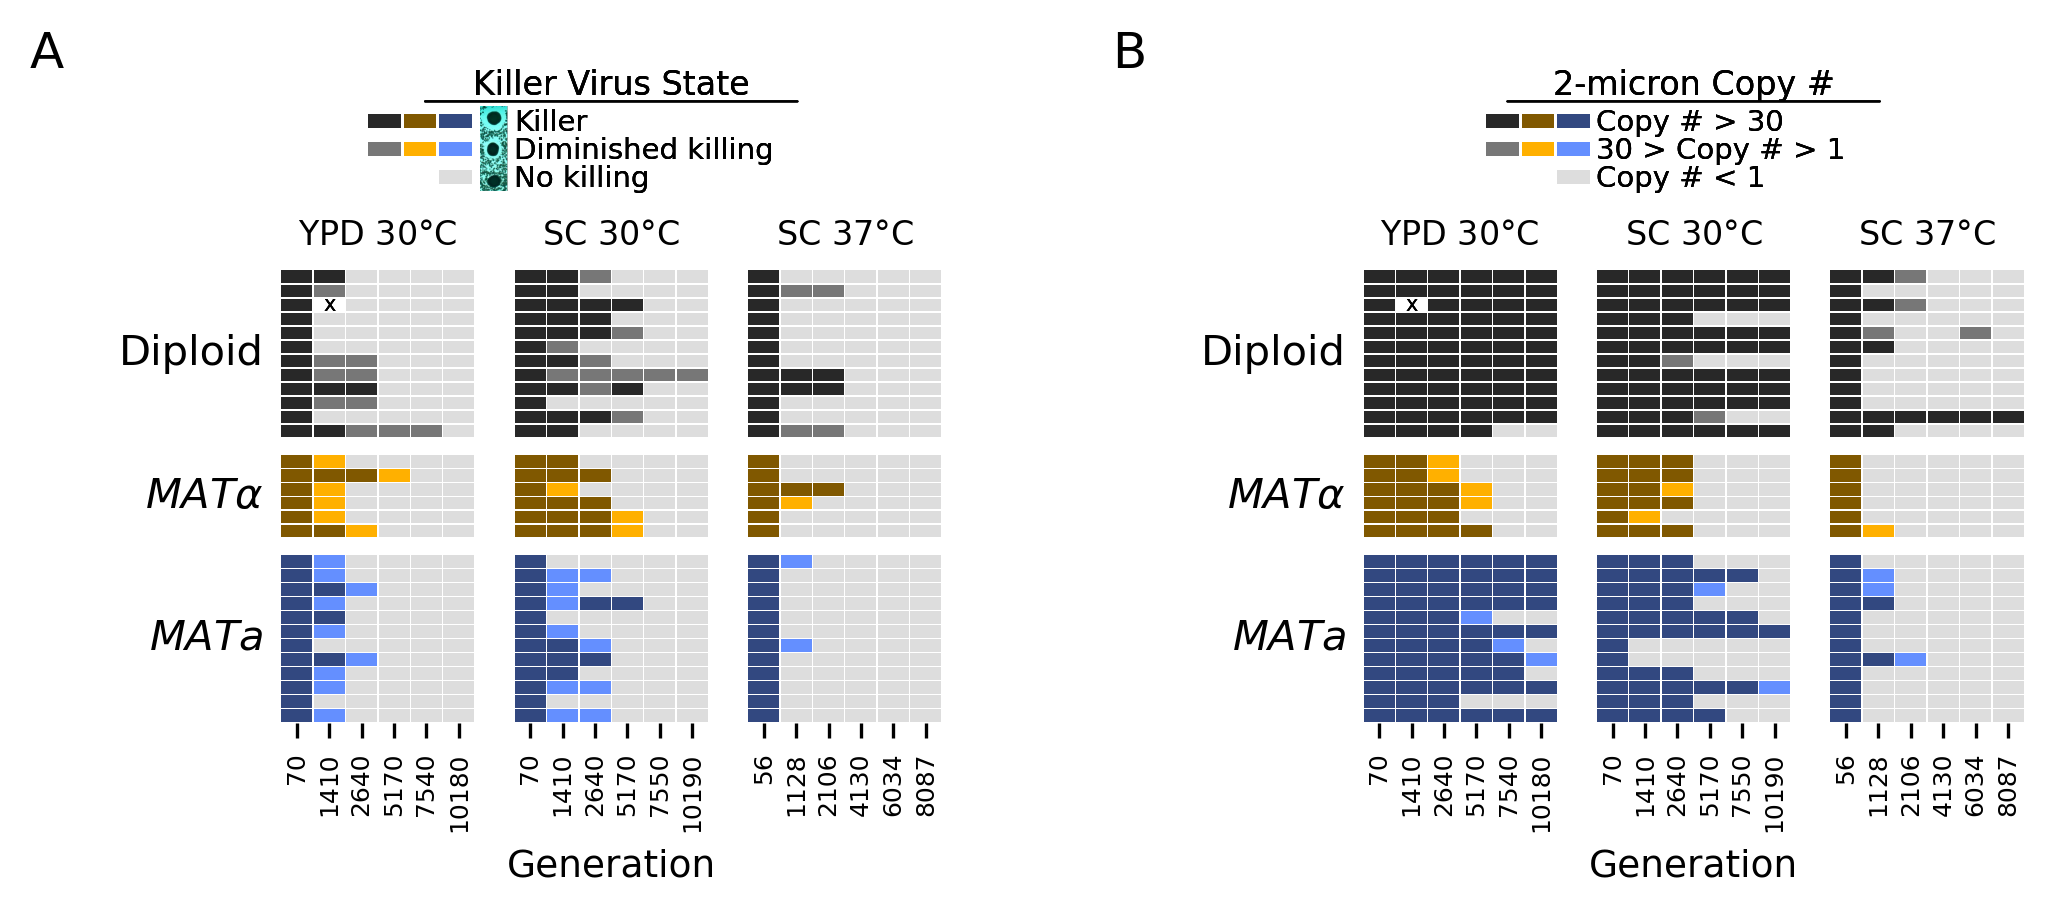

In [11]:
coverage_dats['2-micron']['special_sorter'] = coverage_dats['2-micron']['Well'].apply(lambda w: list(kv3['platewell']).index(w))
td_cov = coverage_dats['2-micron'].sort_values(by='special_sorter')
f = pl.figure(figsize=(7.5,2), dpi=300)
gs0 = gridspec.GridSpec(32, 5)

subps = [[pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[:12, 3:])],
         [pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[13:19, 3:])],
         [pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[20:32, 3:])],
         ]

for s in range(3):
    strain = strains[s]
    subs = subps[s]
    strain_col = to_rgba(color_by_strain[strain])
    if strain == 'diploid':
        strain_col = to_rgba('#777777')
    else:
        strain_col = to_rgba(color_by_strain[strain])
    if strain == 'diploid':
        strain_col_darker = (strain_col[0]/3, strain_col[1]/3, strain_col[2]/3, 1)
    else:
        strain_col_darker = (strain_col[0]-strain_col[0]/2, strain_col[1]-strain_col[1]/2, strain_col[2]-strain_col[2]/2, 1)
    custom_cmap = ListedColormap(['w', '#DDDDDD', strain_col, strain_col_darker])
    subps[0][1].add_patch(Rectangle((-3.4+s*1.1, -11.1), 1, 1, fc=strain_col_darker, clip_on=False))
    subps[0][1].add_patch(Rectangle((-3.4+s*1.1, -9.1), 1, 1, fc=strain_col, clip_on=False))
    for p in range(3):
        f.add_subplot(subs[p])
        plate = plates[p]
        td = td_cov[(td_cov['Plate']==plate) & (td_cov['Strain']==strain)]
        #print(plate, strain, list(td['Well']))
        sns.heatmap(np.array(td[['binned_'+str(g) for g in seq_gens]]), linewidths=0.1, cmap=custom_cmap, cbar=False, ax=subs[p], vmin=-1, vmax=2)
        subs[p].set_yticks([])
        if s == 2:
            subs[p].set_xticks([i+0.5 for i in range(6)])
            subs[p].set_xticklabels([int(gen_fixer[seq_gens[i]][plate]) for i in range(6)], fontsize=6, rotation='vertical')
            if p == 1:
                subs[p].set_xlabel('Generation', fontsize=9)
        else:
            subs[p].set_xticks([])
        if s == 0:
            subs[p].set_title(plate2env[plate], fontsize=8)
        if p == 0:
            subs[p].set_ylabel(strains_for_print[strain], rotation='horizontal', ha='right', va='center')
            
    subps[0][1].add_patch(Rectangle((-1.2, -7.1), 1, 1, fc='#DDDDDD', clip_on=False))
    subps[0][1].annotate('2-micron Copy #', xy=(3, -12), xycoords="data", ha='center', va='bottom', annotation_clip=False, fontsize=8)
    subps[0][1].annotate('', xy=(-3, -12), xytext=(9,-12), xycoords="data", annotation_clip=False, arrowprops=dict(arrowstyle='-', lw=0.5))
    subps[0][1].annotate('Copy # < 1', xy=(0, -6.5), xycoords="data", ha='left', va='center', annotation_clip=False, fontsize=7)
    subps[0][1].annotate('30 > Copy # > 1', xy=(0, -8.5), xycoords="data", ha='left', va='center', annotation_clip=False, fontsize=7)
    subps[0][1].annotate('Copy # > 30', xy=(0, -10.5), xycoords="data", ha='left', va='center', annotation_clip=False, fontsize=7)
    subps[0][0].annotate('x', xy=(1.5, 2.5), xycoords="data", ha='center', va='center', fontsize=5)
    
subps[0][0].annotate('B', fontsize=12, xy=(-1.2, 2.2), xycoords="axes fraction", horizontalalignment="center")
    
subps = [[pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[:12, :2])],
         [pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[13:19, :2])],
         [pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[20:32, :2])],
         ]

for s in range(3):
    strain = strains[s]
    subs = subps[s]
    if strain == 'diploid':
        strain_col = to_rgba('#777777')
    else:
        strain_col = to_rgba(color_by_strain[strain])
    if strain == 'diploid':
        strain_col_darker = (strain_col[0]/3, strain_col[1]/3, strain_col[2]/3, 1)
    else:
        strain_col_darker = (strain_col[0]-strain_col[0]/2, strain_col[1]-strain_col[1]/2, strain_col[2]-strain_col[2]/2, 1)
    custom_cmap = ListedColormap(['w', '#DDDDDD', strain_col, strain_col_darker])
    subps[0][1].add_patch(Rectangle((-4.5+s*1.1, -11.1), 1, 1, fc=strain_col_darker, clip_on=False))
    subps[0][1].add_patch(Rectangle((-4.5+s*1.1, -9.1), 1, 1, fc=strain_col, clip_on=False))
    for p in range(3):
        f.add_subplot(subs[p])
        plate = plates[p]
        td = kv3[(kv3['Plate']==plate) & (kv3['strain']==strain)]
        #print(plate, strain, list(td['Well']))
        if plate=='P1' and strain=='diploid':
            #P1C07 G1410 was contaminated, making it white
            tmp = np.array(td[['G70', 'G1410', 'G2640', 'G5150', 'G7530', 'G10150']])
            tmp[list(td['platewell']).index('P1C07'), 1] = -1
            sns.heatmap(tmp, linewidths=0.1, ax=subs[p], cmap=custom_cmap, cbar=False, vmin=-1, vmax=2)
        else:
            sns.heatmap(np.array(td[['G70', 'G1410', 'G2640', 'G5150', 'G7530', 'G10150']]), linewidths=0.1, ax=subs[p], cmap=custom_cmap, cbar=False, vmin=-1, vmax=2)
        subs[p].set_yticks([])
        if s == 2:
            subs[p].set_xticks([i+0.5 for i in range(6)])
            subs[p].set_xticklabels([int(gen_fixer[seq_gens[i]][plate]) for i in range(6)], fontsize=6, rotation='vertical')
            if p == 1:
                subs[p].set_xlabel('Generation', fontsize=9)
        else:
            subs[p].set_xticks([])
        if s == 0:
            subs[p].set_title(plate2env[plate], fontsize=8)
        if p == 0:
            subs[p].set_ylabel(strains_for_print[strain], rotation='horizontal', ha='right', va='center')
            
    subps[0][1].add_patch(Rectangle((-2.3, -7.1), 1, 1, fc='#DDDDDD', clip_on=False))
    subps[0][1].annotate('Killer Virus State', xy=(3, -12), xycoords="data", ha='center', va='bottom', annotation_clip=False, fontsize=8)
    subps[0][1].annotate('', xy=(-3, -12), xytext=(9,-12), xycoords="data", annotation_clip=False, arrowprops=dict(arrowstyle='-', lw=0.5))
    subps[0][1].annotate('No killing', xy=(0, -6.5), xycoords="data", ha='left', va='center', annotation_clip=False, fontsize=7)
    subps[0][1].annotate('Diminished killing', xy=(0, -8.5), xycoords="data", ha='left', va='center', annotation_clip=False, fontsize=7)
    subps[0][1].annotate('Killer', xy=(0, -10.5), xycoords="data", ha='left', va='center', annotation_clip=False, fontsize=7)
    subps[0][0].annotate('x', xy=(1.5, 2.5), xycoords="data", ha='center', va='center', fontsize=5)
    
inset = pl.axes([0,0,1,1], label=str(p))
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(subps[0][2], [-1.4,1.47,0.2,0.5])
inset.set_axes_locator(ip)
inset.imshow(pl.imread('../Data/KV/strips_formatted/KV_11_09_P3_alpha_killing.png')[210:490, 120:215])
inset.set_xticks([])
inset.set_yticks([])

subps[0][0].annotate('A', fontsize=12, xy=(-1.2, 2.2), xycoords="axes fraction", horizontalalignment="center")
            
sns.despine(left=True, bottom=True)

f.savefig('../Output/Figs/Figure10_Element_loss.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

# Plotting copy number of a couple highly variable regions:

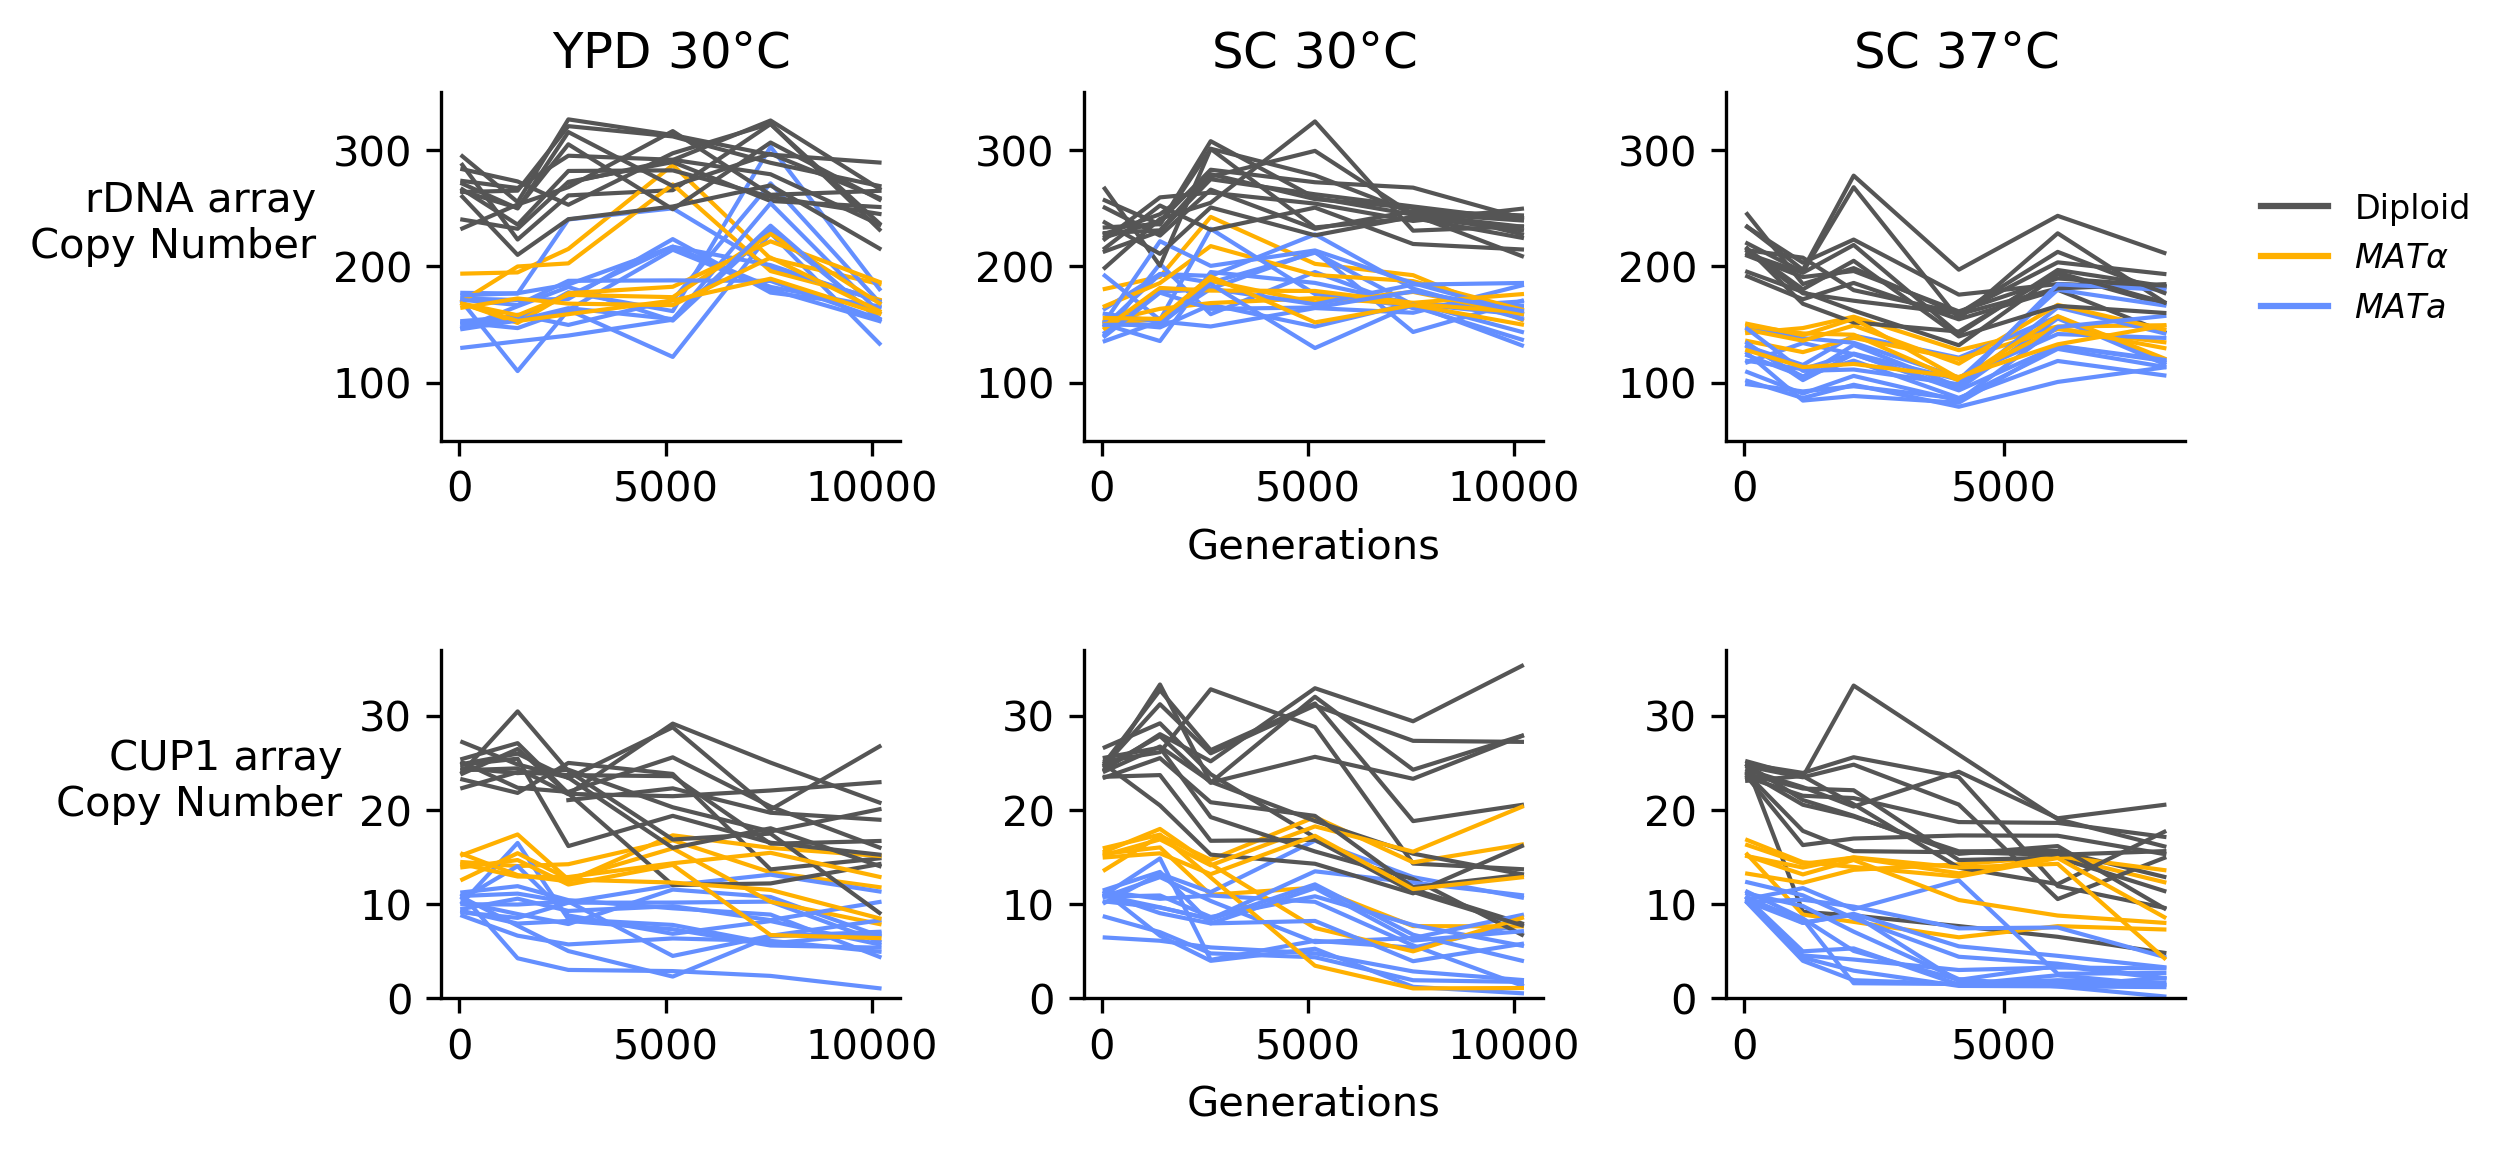

In [21]:

f, subps = pl.subplots(2, 3, figsize=(7.5,4), dpi=300)
gs0 = gridspec.GridSpec(32, 5)
subs = [subps[i][j] for i in range(2) for j in range(3)]
plotters = ['rDNA_array', 'CUP_array']
names = ['rDNA array\nCopy Number', 'CUP1 array\nCopy Number']
ylims = [(50,350), (0, 37), (0, 10)]
pl.subplots_adjust(hspace=0.6, wspace=0.4)

for c in range(2):
    plotter = plotters[c]
    subs[c*3].set_ylabel(names[c], rotation='horizontal', ha='right')
    for p in range(3):
        if c == 0:
            subs[p].set_title(plate2env[plates[p]])
        sub = subs[c*3+p]
        td_cov = coverage_dats[plotter][coverage_dats[plotter]['Plate']==plates[p]]
        for j, row in td_cov.iterrows():
            sub.plot([gen_fixer[sg][plates[p]] for sg in seq_gens], [row[sg] for sg in seq_gens], c=color_by_strain[row['Strain']], lw=1)
        sub.set_ylim(ylims[c])
        if p==1:
            sub.set_xlabel('Generations', y=-2)
    
for i in color_by_strain:    
    subs[2].plot([], [], c=color_by_strain[i], label=strains_for_print[i])

subs[2].legend(frameon=False, fontsize=8, bbox_to_anchor=(1.1, 0.8))
            
sns.despine()

f.savefig('../Output/Figs/supp_figs/coverage_of_arrays.png', background='transparent', bbox_inches='tight', pad_inches=0.1)

In [23]:
wellinfo

plate.well    contam      strain plate_well
0       P1_A01     blank       blank      P1A01
1       P1_A02     blank       blank      P1A02
2       P1_A03        No           a      P1A03
3       P1_A04        No           a      P1A04
4       P1_A05        No           a      P1A05
..         ...       ...         ...        ...
379     P4_H08        No  cerevisiae      P4H08
380     P4_H09        No       pombe      P4H09
381     P4_H10  glabrata    glabrata      P4H10
382     P4_H11        No       pombe      P4H11
383     P4_H12        No       pombe      P4H12

[384 rows x 4 columns]

## Looking for any association between mutations and 2-micron loss

In [12]:
# a dataframe with hits and multiplicity for each ORF in the yeast genome
orf_hit_df = pd.read_csv('../Output/WGS/combined_option/gene_hit_data.tsv', delimiter='\t')
orf_hit_df = orf_hit_df.merge(gene_info[['ORF', 'briefDescription', 'Essential_by_Liu2015', 'Essential_by_Giaever2002', 'start', 'end']], on='ORF', how='left')
orf_hit_df = orf_hit_df[~orf_hit_df['CHROM'].isin(['2-micron', 'chrMito'])]

orf_flip = orf_hit_df.set_index("Gene_ORF")[[w for w in wells if w[:2] in ['P1', 'P2'] and well_to_strain[w]=='a']].T.clip(0,1)
orf_flip['Well'] = orf_flip.apply(lambda r: r.name, axis=1)
orfhits_and_coverage = orf_flip.merge(coverage_dats['2-micron'][['Well', 10150]], on='Well', how='inner')
orfhits_and_coverage

RTG3  NUP170  YBR144C  EHT1  TDP1  YBR224W  PHO89  PWP2  AAD3  GUD1  ...  \
0      1       1        1     1     1        1      1     1     1     1  ...   
1      0       0        0     0     0        0      0     0     1     0  ...   
2      0       1        0     0     0        0      0     0     0     0  ...   
3      0       0        0     0     0        0      0     0     0     0  ...   
4      0       0        0     0     0        0      0     0     0     0  ...   
5      0       0        0     0     0        0      0     0     0     0  ...   
6      0       0        0     0     1        0      0     0     0     0  ...   
7      0       0        0     0     0        0      0     0     0     0  ...   
8      0       0        0     0     0        0      0     0     0     0  ...   
9      0       0        0     0     0        0      0     0     0     0  ...   
10     0       0        0     0     0        0      0     1     0     0  ...   
11     0       0        0     0     0        0      0     0     0     0  ...   
12     1       0        0     0     0        0      0     0     0     0  ...   
13     0       0        0     1     0        0      0     1     0     0  ...   
14     0       0        0     0     0        0      0     0     0     0  ...   
15     0       0        0     0     0        0      0     0     0     0  ...   
16     0       0        0     0     1        0      0     0     0     0  ...   
17     0       0        0     0     0        0      0     0     1     0  ...   
18     0       0        0     0     0        0      0     0     1     0  ...   
19     0       0        0     1     0        0      0     0     0     0  ...   
20     0       0        0     0     0        0      0     0     0     0  ...   
21     0       1        0     0     0        0      0     0     0     0  ...   
22     0       0        0     0     0        0      0     0     0     0  ...   
23     0       0        0     0     0        0      0     0     0     0  ...   

    LHS1  ANR2  MAC1  JLP2  YNR014W  LPX1  NFI1  SAM3   Well       10150  
0      0     0     0     0        0     0     0     0  P1B02    0.218896  
1      0     0     0     0        0     0     0     0  P1B03    0.169999  
2      0     0     0     0        0     0     0     0  P1B04  144.216384  
3      0     0     0     0        0     0     0     0  P1C02    0.149547  
4      0     0     0     0        0     0     0     0  P1C04  100.404082  
5      0     0     0     0        0     0     0     0  P1C05   57.611088  
6      0     0     0     0        0     0     0     0  P1C06  167.230861  
7      0     0     0     0        0     0     0     0  P1D03    0.112113  
8      0     0     0     0        0     0     0     0  P1E04  106.420267  
9      0     0     0     0        0     0     0     0  P1F05  117.609767  
10     0     0     0     0        0     0     0     0  P1G04  116.435573  
11     0     0     0     0        0     0     0     0  P1G05    7.853388  
12     0     0     0     0        0     0     0     0  P2B04    0.131697  
13     0     0     0     0        0     0     0     0  P2B05    0.181922  
14     0     0     0     0        0     0     0     0  P2C02    0.146352  
15     0     0     0     0        0     0     0     0  P2C04    0.102511  
16     0     0     0     0        0     0     0     0  P2C05    0.056624  
17     0     0     0     0        0     0     0     0  P2C06    0.101924  
18     0     0     0     0        0     0     0     0  P2D03    0.109466  
19     0     0     0     0        0     0     0     0  P2D06    3.391404  
20     0     0     0     0        0     0     0     0  P2E06    0.132268  
21     0     0     0     0        0     0     0     0  P2F02   74.347431  
22     0     0     0     0        0     0     0     0  P2G04    0.149140  
23     0     0     0     0        0     0     0     0  P2G05    0.061353  

[24 rows x 3887 columns]

In [13]:
mat = []
for orf in [i for i in orfhits_and_coverage if i not in ['Well', 10150]]:
    mat.append([orf] + list(sci_stats.linregress(orfhits_and_coverage[10150], orfhits_and_coverage[orf])))
correlation_results = pd.DataFrame(mat, columns=['Gene_ORF', 'slope', 'intercept', 'rval', 'pval', 'stderr'])
correlation_results.sort_values(by='rval')

Gene_ORF     slope  intercept      rval      pval    stderr
57       ADE6 -0.004237   0.741755 -0.473759  0.019356  0.001679
1773     SES1 -0.003067   0.364671 -0.390437  0.059256  0.001542
42       HIS1 -0.003065   0.364585 -0.390144  0.059464  0.001542
108      FKH2 -0.003064   0.364579 -0.390124  0.059478  0.001542
90      STE11 -0.002630   0.431663 -0.307530  0.143781  0.001735
...       ...       ...        ...       ...       ...       ...
824     MET22  0.002864  -0.023760  0.571271  0.003547  0.000877
776      TEL2  0.002864  -0.023760  0.571271  0.003547  0.000877
827   YOR296W  0.002880  -0.024362  0.574482  0.003325  0.000875
324      DGK1  0.003245  -0.038002  0.647247  0.000629  0.000815
285     MLO50  0.004329  -0.036861  0.721573  0.000069  0.000886

[3885 rows x 6 columns]

## Nothing convincing / nothing that would pass a multiple-hypothesis correction

## KV raw data:

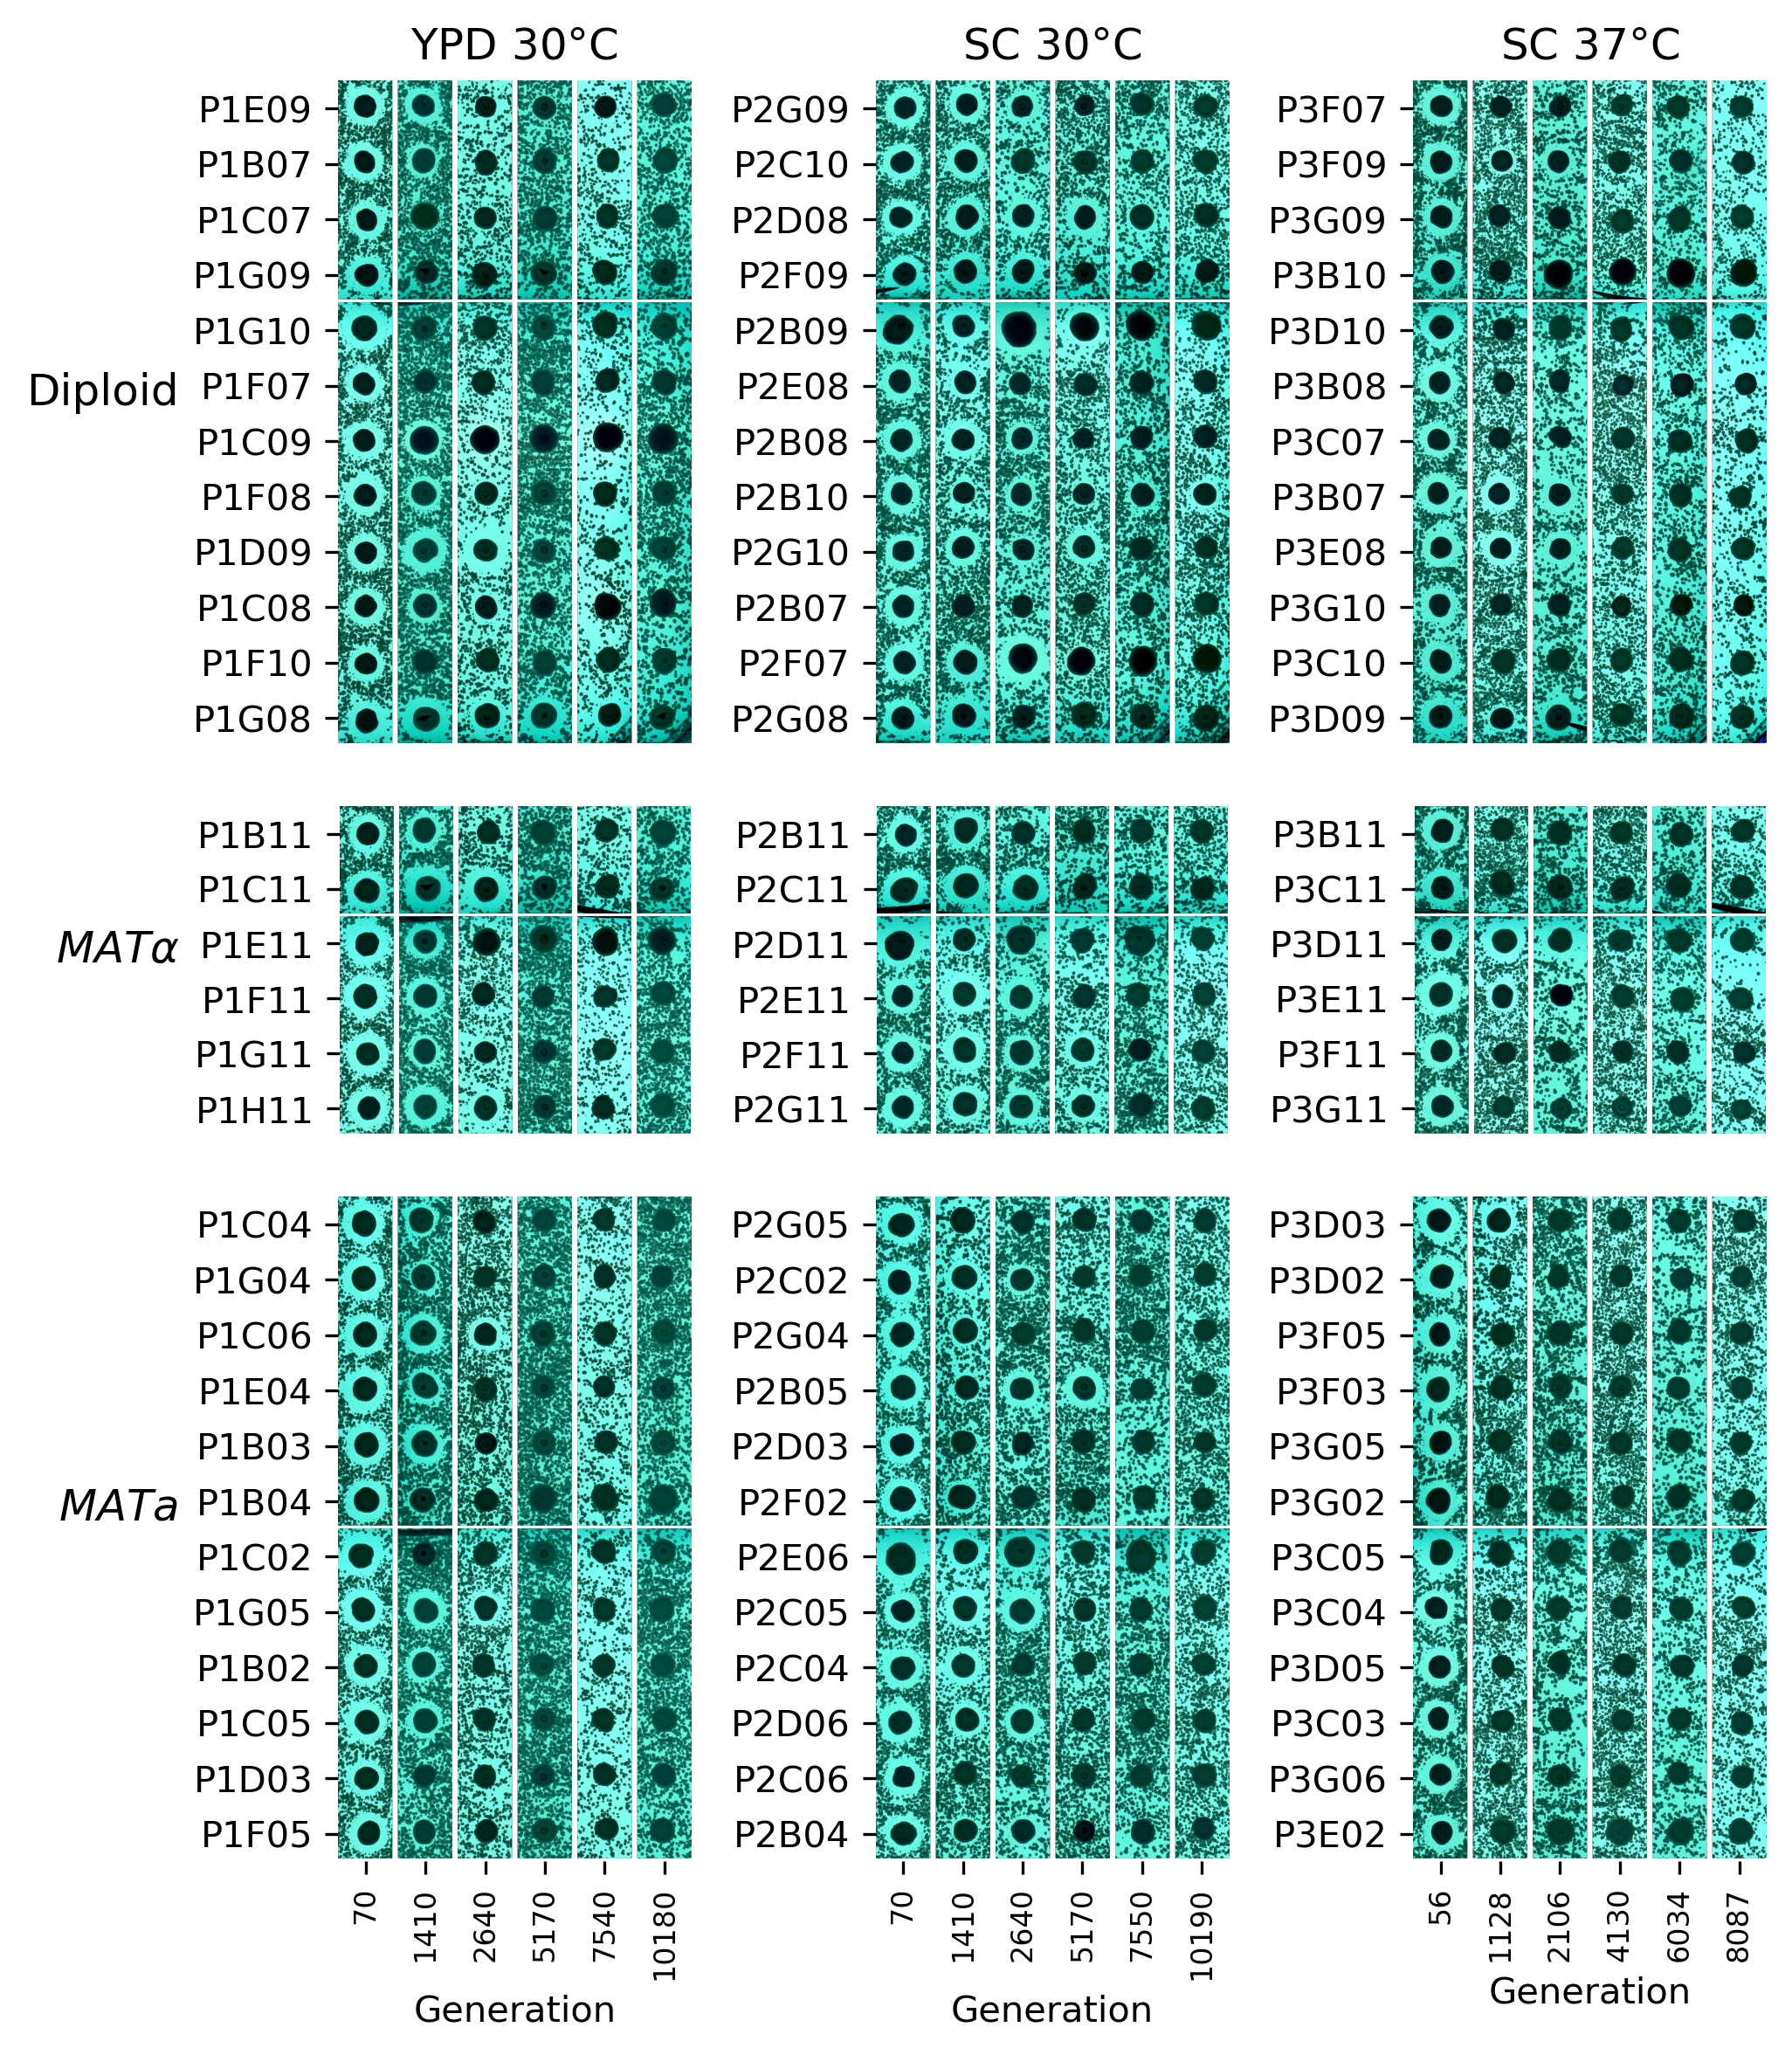

In [14]:
f = pl.figure(figsize=(7.5,9), dpi=300)
pic_start = 0
gs0 = gridspec.GridSpec(pic_start+20*2+12*2, 1)
subps = [
         [pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[pic_start:pic_start+12*2, :])],
         [pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[pic_start+13*2:pic_start+19*2, :])],
         [pl.Subplot(f, g) for g in gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[pic_start+20*2:pic_start+20*2+12*2, :])]
        ]
rows_by_strain = {'a': 12, 'alpha': 6, 'diploid': 12}
for s in range(3):
    strain = strains[s]
    imsubs = subps[s]
    for p in range(3):
        f.add_subplot(imsubs[p])
        plate = plates[p]
        td = kv3[(kv3['Plate']==plate) & (kv3['strain']==strain)]
        imsubs[p].imshow(pl.imread('../Data/KV/strips_formatted/KV_11_09_' + plate + '_' + strain + '_killing.png'))
        imsubs[p].set_yticks([102*i+51 for i in range(rows_by_strain[strain])])
        imsubs[p].set_yticklabels([plate+i for i in list(td['Well'])])
        imsubs[p].set_xticks([])
        if s == 2:
            imsubs[p].set_xticks([110*i+50 for i in range(6)])
            imsubs[p].set_xticklabels([int(gen_fixer[seq_gens[i]][plate]) for i in range(6)], fontsize=8, rotation='vertical')
            imsubs[p].set_xlabel('Generation', fontsize=10)
        if s == 0:
            imsubs[p].set_title(plate2env[plate])
        if p == 0:
            imsubs[p].set_ylabel(strains_for_print[strain], rotation='horizontal', ha='right', fontsize=12)
            
sns.despine(left=True, bottom=True)

f.savefig('../Output/Figs/supp_figs/Figure10supp_rawKV.png', background='transparent', bbox_inches='tight', pad_inches=0.1)